## Final Project Submission

Please fill out:
* Student name: Alexandra Yakovleva 
* Student pace: flex / part time 
* Scheduled project review date/time: 1/26/2024 
* Instructor name: Morgan Jones
* Blog post URL:


## Let's begin!
The assignment states the business problem as following:

<i>
Your company is expanding in to new industries to diversify its portfolio. Specifically, they are interested in purchasing and operating airplanes for commercial and private enterprises, but do not know anything about the potential risks of aircraft. You are charged with determining which aircraft are the lowest risk for the company to start this new business endeavor. You must then translate your findings into actionable insights that the head of the new aviation division can use to help decide which aircraft to purchase.
</i>

Here's my roadmap for the asignment:

1. Load the dataset.
2. Get a brief look at dataset to identify columns that can be discarded.
3. For a smaller subset, perform data cleaning and filtering.
4. Visualize info related to Accdents with various Injury rates over the years for different Makes, Models.
5. Saved the cleaned up set for Tabelau use.

I'll use Pandas and Matplotlib to load, clean up, filter, and visualize the aviation accidents data. 

## 1. Dataset

To answer the stated problem, we'll be using [Kaggle's Aviation Accident Database](https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses).
Start with importing Python libraries.

In [212]:
# start with importing Python data loading and data analysis libraries

# for dataframe management
import pandas as pd
# for stats, if needed
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for loading/saving locally
import os

# display plots inline
%matplotlib inline


Specify directories that contain the data.

In [213]:
# Specify the data directory and the data file name
directory = 'data'
file_name = 'Aviation_Data.csv'


# Join the directory and file name using os.path.join
file_path = os.path.join(directory, file_name)

# Read the accidents CSV file into a DataFrame
aviation_accidents_df = pd.read_csv(file_path, low_memory=False)
aviation_accidents_df.head()

# load the state codes
file_codes_name = 'USState_Codes.csv'
file_path_StateCodes = os.path.join(directory, file_codes_name)
state_codes_df = pd.read_csv(file_path_StateCodes)

#show df info
aviation_accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

Each row contains information about an aviation accident (what, when, where, how). 
Our dataset has 31 columns and 90348 entries.
Just by looking at the head of the dataset, there's a lot of missing data. We're going to take a look at the value ranges of the columns next to decide on what information to keep and what to drop.

In [214]:
# supplemental function that will generate info for each column of the inputDF
def output_df_column_summary(inputDF):
    for column in inputDF.columns:
        unique_values = inputDF[column].unique()
        count_per_category = inputDF[column].value_counts()
    
        print(f"Column: {column}")
        #print("Unique values:", unique_values)
        print("Count per category:")
        print(count_per_category)
        print("\n")
    
# output df info    
output_df_column_summary(aviation_accidents_df)

Column: Event.Id
Count per category:
20001214X45071    3
20001212X19172    3
20001214X35574    2
20001214X38941    2
20001212X21058    2
                 ..
20030402X00420    1
20001212X18923    1
20001213X26321    1
20120620X91512    1
20220704105416    1
Name: Event.Id, Length: 87951, dtype: int64


Column: Investigation.Type
Count per category:
Accident      85015
Incident       3874
25-09-2020      702
26-09-2020       60
02-02-2021       39
              ...  
18-11-2020        1
06-01-2021        1
11-02-2021        1
05-04-2021        1
05-08-2022        1
Name: Investigation.Type, Length: 71, dtype: int64


Column: Accident.Number
Count per category:
WPR22LA143    2
WPR23LA045    2
CEN23MA034    2
DCA23WA071    2
DCA22WA130    2
             ..
CEN20LA357    1
WPR12FA193    1
ERA10LA082    1
DEN88LA169    1
MIA96LA171    1
Name: Accident.Number, Length: 88863, dtype: int64


Column: Event.Date
Count per category:
1984-06-30    25
2000-07-08    25
1982-05-16    25
1984-08-25    

|Column Name | Column Description | What are we going to do |
|------------|--------------------|------------------------|
| Event.Id   | Event ID, some values repeat, likely when plane A got tangled up with plane B.| Drop it|
|Investigation.Type|Mostly Accident/Incident but dates got mixed into it| Clean up: filter out 'Incident'|
|Accident.Number| Similar to event ID| Drop it|
|Event.Date|When it happened| Keep, convert to date, filter the last 20 years|
|Location|Where it happened, nearest city| Icomplete geo info, duplicates Lat/Long. Split into city/state columns|
|Country|Where it happened|Majority is in US, filter by 'US'|
|Latitude| Where exactly it happened | Important for future viz, data is mixed, convert to same format| 
|Longitude|Where exactly it happened| Important for future viz, data is mixed, convert to same format|
|Airport.Code|Where it hapened| Drop it|
|Airport.Name| Where it hapened | Drop it|
|Injury.Severity| What hapened/How severe | Has mixed data format, convert to categorical.
|Aircraft.damage| Was the aircraft damaged| Data looks OK, do minor cleaning with the cathegories|
|Aircraft.Category| Type of carrier |Clean up|
|Registration.Number|-| Drop it|
|Make|Manufacturer| Clean up, has duplicates| 
|Model|Model Code|Keep, investigate|
|Amateur.Built|Yes/No| Filter out Amaterur Built| 
|Number.of.Engines|-|Data looks OK, keep|
|Engine.Type|-|Clean up data| 
|FAR.Description|Code describing the aircraft purpose, 91 General Op, 121, 129 Commercal, 135 Commuter |?|
|Schedule|If flight was scheduled or not|Drop it|
|Purpose.of.flight|-|Keep it, we'll filter it by Commercial, Business, Personal, Instructional|
|Air.carrier|Air Carrier Info|?|
|Total.Fatal.Injuries|-|Clean up, drop NaNs|
|Total.Serious.Injuries|-| Clean up, drop NaNs|
|Total.Minor.Injuries|-| Clean up, drop NaNs|
|Total.Uninjured|-|Clean up, drop NaNs|
|Weather.Condition|Weather condition code|Drop it, we don't know what the codes mean|
|Broad.phase.of.flight|Code for the phase of flight|Keep it|
|Report.Status|-|Drop it|
|Publication.Date|-|Drop it|

  ## 2. Selecting relevant columns from the datset.
Before removing columns from the dataset, let's do some exploration. The data we're working with was collecter over half a century, and during the collection time, the reporting standards have been revised, reporting format changed (i.e, columns being added and removed). For our business objecive, the columns we would like to keep are:
```['Event.Date', 'Make', 'Model', 'Purpose.of.flight', 'Injury.Severity']```. We're going to identify columns that positively impact (add information) the categorical data in these columns as well as the columns we need to remove because they have no impact or negative impact on future data manipulation.

In [215]:
# add a year column 
aviation_accidents_df['Event.Date'] = pd.to_datetime(aviation_accidents_df['Event.Date'])
try:
    aviation_accidents_df['Year'] = aviation_accidents_df['Event.Date'].dt.year
except Exception as e:
    print(f"An error occurred: {e}")
    # Handle the error here, e.g., fill NaN values with a default year
    aviation_accidents_df['Year'] = default_year

#columns we'd like to keep     
cols_to_keep = ['Year', 'Make', 'Model', 'Purpose.of.flight', 'Injury.Severity']
#columns we'll investigate
cols_to_investigate = ['Broad.phase.of.flight', 'Latitude', 'Longitude', 'Aircraft.Category']

# columns we're going to exclude from the analysis
cols_to_remove = ['Event.Id', 'Accident.Number', 'Airport.Code', 'Airport.Name', 'Registration.Number', \
                  'Schedule', 'Weather.Condition', \
                  'Publication.Date', 'Report.Status']

# make a copy with cols to keep and to investigate
compact_aa_df = aviation_accidents_df.drop(columns=cols_to_remove)

#what happens if keep all remaining columns 
output_df_column_summary(compact_aa_df.dropna())

for c in cols_to_investigate:
    print('------Removing ' + c + ':--------')
    df_reduced = compact_aa_df.drop(columns=c)
    df_clean = df_reduced.dropna()
    output_df_column_summary(df_clean[cols_to_keep])
    print(df_clean[cols_to_keep].info())


Column: Investigation.Type
Count per category:
Series([], Name: Investigation.Type, dtype: int64)


Column: Event.Date
Count per category:
Series([], Name: Event.Date, dtype: int64)


Column: Location
Count per category:
Series([], Name: Location, dtype: int64)


Column: Country
Count per category:
Series([], Name: Country, dtype: int64)


Column: Latitude
Count per category:
Series([], Name: Latitude, dtype: int64)


Column: Longitude
Count per category:
Series([], Name: Longitude, dtype: int64)


Column: Injury.Severity
Count per category:
Series([], Name: Injury.Severity, dtype: int64)


Column: Aircraft.damage
Count per category:
Series([], Name: Aircraft.damage, dtype: int64)


Column: Aircraft.Category
Count per category:
Series([], Name: Aircraft.Category, dtype: int64)


Column: Make
Count per category:
Series([], Name: Make, dtype: int64)


Column: Model
Count per category:
Series([], Name: Model, dtype: int64)


Column: Amateur.Built
Count per category:
Series([], Name: Amate

My conclusion would be to remove ```'Broad.phase.of.flight'``` column and keep ```'Latitude', 'Longitude', 'Aircraft.Category'``` as they contain relevant information. Looks like ```'Broad.phase.of.flight'``` info was discontinued after 2007 and by removing it, we recover almost 16000 valid entries we otherwise would have lost.

In [216]:
#update columns to remove
cols_to_remove = ['Event.Id', 'Accident.Number', 'Airport.Code', 'Airport.Name', 'Registration.Number', \
                  'Schedule', 'Weather.Condition', \
                  'Publication.Date', 'Report.Status', 'Broad.phase.of.flight']
#overwrite df slice
compact_aa_df = aviation_accidents_df.drop(columns=cols_to_remove)

What about 'FAR.Description' and 'Air.carrier'? Let's see what is the distribution of values in ```['Purpose.of.flight', 'Make', 'Model', 'Event.Date', 'Injury.Severity']``` look like. 
[According to FAA](https://www.faa.gov/hazmat/air_carriers/operations), codes '121' and '129' describe Domestic and Foreign Air Carriers operations.

In [217]:
#investigate 'FAR.Description', 'Air.carrier'
cols_of_interest = ['Purpose.of.flight', 'Make', 'Model', 'Event.Date', \
                    'Injury.Severity', 'FAR.Description', 'Air.carrier']

df_slice = compact_aa_df[cols_of_interest]
print('-------FAR.Description top 10 values------')
print(df_slice['FAR.Description'].value_counts().nlargest(10))


# check how 'FAR.Description' fligts with 121/129 code are described because there's no commercial flights category  
df_has_121_129_info = df_slice[df_slice['FAR.Description'].str.contains('121|129', na=False)]
output_df_column_summary(df_has_121_129_info)


-------FAR.Description top 10 values------
091                              18221
Part 91: General Aviation         6486
NUSN                              1584
NUSC                              1013
137                               1010
135                                746
121                                679
Part 137: Agricultural             437
UNK                                371
Part 135: Air Taxi & Commuter      298
Name: FAR.Description, dtype: int64
Column: Purpose.of.flight
Count per category:
Unknown            164
Positioning          3
Business             2
Public Aircraft      1
Name: Purpose.of.flight, dtype: int64


Column: Make
Count per category:
BOEING              418
Boeing              181
AIRBUS               97
EMBRAER              55
BOMBARDIER INC       52
                   ... 
EMBRAER S.A.          1
Curtis-wright         1
Robinson              1
Mcdonald Douglas      1
Saab                  1
Name: Make, Length: 93, dtype: int64


Column: Model
Cou

## 3. Data Cleaning.

1. Replacing all dates in ```Investigation.Type``` with 'Unknown'
2. Splitting ```Location``` into ```City```, ```State```, capitalizing the city name.
3. Cleaning up ```Country```.
4. ```Latitude```, ```Longitude``` are a mix of DMS (degrees-minutes-seconds) and decimal degrees. We'll need to convert it to a uniform format (decimal degree coordinate).
5. Convert categorical values in ```Injury.Severity``` to Fatal, Non-Fatal, Incident.
6. Clean up ```Aircraft.Category```.
7. Unify categorical data in ```Make```, ```Model```.
8. Based on ```'FAR.Description'``` codes, add 'Commercial' to ```'Purpose.of.flight'```.
9. Do misc cleanup and save the dataset.

In [218]:
#1 'Investigation.Type': Replace dates with Unknown 
valid_values = ['Accident', 'Incident']
compact_aa_df['Investigation.Type'].fillna('Unknown', inplace=True)
compact_aa_df.loc[~compact_aa_df['Investigation.Type'].isin(valid_values), 'Investigation.Type'] = 'Unknown'
compact_aa_df['Investigation.Type'].describe()

#2 'Location' split into City and State
compact_aa_df['Location'].fillna('Unknown', inplace=True)
city_state = compact_aa_df['Location'].str.replace(' ', '').str.split(',', expand=True)

#insert before country
insert_location = compact_aa_df.columns.get_loc('Location') + 1

# Insert the new column at the specified location
compact_aa_df.insert(insert_location, 'City', city_state.iloc[:, 0].str.title())
compact_aa_df.insert(insert_location + 1, 'State', city_state.iloc[:, 1])

#drop location
compact_aa_df.drop(columns='Location', inplace=True)

In [219]:
# 'State'contains either a valid state or a duplicate of a country. remove everything that is not a valid state.
# Create a mapping dictionary
abbreviation_mapping = dict(zip(state_codes_df['Abbreviation'], state_codes_df['Abbreviation']))

# Map the values in df2['State']
compact_aa_df['State'] = compact_aa_df['State'].apply(lambda x: abbreviation_mapping.get(x, None))

#3 'Country': replace NaN with Unknown and title
compact_aa_df['Country'].fillna('Unknown', inplace=True)
compact_aa_df['Country'] = compact_aa_df['Country'].str.title()

For #5, we'll implement a function that'll convert DMS geo data into decimal number. As we saw, the data type in the column is either nan, NaN, a decimal coordinate, or a DMS coordinate. 

In [220]:
import re
# check for DMS pattern in a string: ends with 4 types of letters the rest are nubers including 0
def is_dms(coordinate_dms):
    # regular expression pattern for DMS format
    dms_pattern = re.compile(r'^0?\d+?[NSEW]$')
    # If the string matches the DMS pattern
    return bool(dms_pattern.match(coordinate_dms))

def dms2decimal(coordinate):
# Converting DMS data to decimal degree data
   
    # check for float values first
    if isinstance(coordinate, float):
        return coordinate
    
    # do conversion in try-catch block
    decimal_degrees = float('nan')
    try:
        # if its DMS, convert
        if is_dms(coordinate):
            direction = coordinate[-1]
            deg_min_sec = coordinate[:-1]
            # Extract seconds (last two), minutes (middle two), degrees (everything else)
            seconds = int(deg_min_sec[:-2])            
            minutes = int(deg_min_sec[-4:-2])
            degrees = int(deg_min_sec[:-4])

            # Convert to decimal degrees
            decimal_degrees = degrees + (minutes / 60) + (seconds / 3600)

            # Add a negative sign for the Northern or Western hemisphere
            
            if (direction in ['S', 'W']):
                decimal_degrees *= -1
        #if not DMS, try converting to float  
        else:
            decimal_degrees = float(coordinate)
    except TypeError as te:
        print(f'A type error occurred: {te}')
        print(coordinate)
    except ValueError as ve:
        print(f'A value error occurred: {ve}')
        print(coordinate)
        
    return decimal_degrees

In [221]:
#4. 'Latitude', 'Longitude' convert to decimals
non_nan_values_lat = compact_aa_df['Latitude'].notna()
compact_aa_df.loc[non_nan_values_lat, 'Latitude'] = \
    compact_aa_df.loc[non_nan_values_lat, 'Latitude'].apply(dms2decimal)

non_nan_values_long = compact_aa_df['Longitude'].notna()
compact_aa_df.loc[non_nan_values_long, 'Longitude'] = \
    compact_aa_df.loc[non_nan_values_long, 'Longitude'].apply(dms2decimal)

In [222]:
# 5.'Injury.Severity': replace all Fatal(xx) with Fatal, replace 'Minor' or 'Serious' with Non-Fatal
compact_aa_df['Injury.Severity'] = compact_aa_df['Injury.Severity'].str.replace('^Fatal.*', 'Fatal')
compact_aa_df['Injury.Severity'] = compact_aa_df['Injury.Severity'].str.replace('Minor', 'Non-Fatal')
compact_aa_df['Injury.Severity'] = compact_aa_df['Injury.Severity'].str.replace('Serious', 'Non-Fatal')
# If Injury.Severity is NaN but Total.Fatal.Injuries >0 then rename it to Fatal, otherwise 'Non-Fatal'
idx_has_fatality = compact_aa_df['Total.Fatal.Injuries'] > 0
idx_has_no_fatality = compact_aa_df['Total.Fatal.Injuries'] == 0
compact_aa_df.loc[idx_has_fatality, 'Injury.Severity'] = 'Fatal'
compact_aa_df.loc[idx_has_no_fatality, 'Injury.Severity'] = 'Non-Fatal'

#'Aircraft.damage': replace nan values with Unknown 
compact_aa_df['Aircraft.damage'].fillna('Unknown', inplace=True)

# 6. 'Aircraft.Category' replace nan with Unknown, 
# replace ULTR with Ultralight, WSFT with Weightshift, UNK with Unknown 
compact_aa_df['Aircraft.Category'].fillna('Unknown', inplace=True)
compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('ULTR', 'Ultralight')
compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('WSFT', 'Weight-Shift')
compact_aa_df['Aircraft.Category'] = compact_aa_df['Aircraft.Category'].str.replace('UNK', 'Unknown')


# 7 'Make', 'Model': Use str.title for all aircrtaft makes to get rid of duplicates
# 'Make', use split and keep the first word only
compact_aa_df['Make'] = (compact_aa_df['Make'].str.title()).str.split().str[0]
compact_aa_df['Model'] = compact_aa_df['Model'].str.title()

# 8. Purpose.of.flight add 'Commercial' based on FAR.description containing 121 or 129
idx_has_121_129_info = compact_aa_df['FAR.Description'].str.contains('121|129', na=False)
compact_aa_df.loc[idx_has_121_129_info, 'Purpose.of.flight'] = 'Commercial'
compact_aa_df[compact_aa_df['Purpose.of.flight'] == 'Commercial'].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190 entries, 5 to 90338
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Investigation.Type      1190 non-null   object        
 1   Event.Date              1190 non-null   datetime64[ns]
 2   City                    1190 non-null   object        
 3   State                   707 non-null    object        
 4   Country                 1190 non-null   object        
 5   Latitude                699 non-null    object        
 6   Longitude               699 non-null    object        
 7   Injury.Severity         1190 non-null   object        
 8   Aircraft.damage         1190 non-null   object        
 9   Aircraft.Category       1190 non-null   object        
 10  Make                    1183 non-null   object        
 11  Model                   1182 non-null   object        
 12  Amateur.Built           1185 non-null   object 

In [223]:
# 9. 'Amateur.Built' replace NA with Unknown
compact_aa_df['Amateur.Built'].fillna('Unknown', inplace=True)

# drop Air.carrier, FAR.Description 
compact_aa_df.drop(columns=['Air.carrier', 'FAR.Description'], inplace=True)

compact_aa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Investigation.Type      90348 non-null  object        
 1   Event.Date              88889 non-null  datetime64[ns]
 2   City                    90348 non-null  object        
 3   State                   82139 non-null  object        
 4   Country                 90348 non-null  object        
 5   Latitude                34382 non-null  object        
 6   Longitude               34373 non-null  object        
 7   Injury.Severity         88889 non-null  object        
 8   Aircraft.damage         90348 non-null  object        
 9   Aircraft.Category       90348 non-null  object        
 10  Make                    88826 non-null  object        
 11  Model                   88797 non-null  object        
 12  Amateur.Built           90348 non-null  object

In [224]:
# add extra Make and Model column
compact_aa_df.loc[:, 'Make.Model'] = compact_aa_df.loc[:, 'Make'] + \
' ' + compact_aa_df.loc[:, 'Model'];

directory_out = 'results'
if not os.path.exists(directory_out):
    # Create the directory if it doesn't exist
    os.makedirs(directory_out)

file_name = 'AviationAccidents_AY.csv'
file_path_Save = os.path.join(directory_out, file_name)
compact_aa_df.to_csv(file_path_Save, index=False)


## 4. Exploratory analysis.

We'll work on further reducing the dataset, dropping NaNs and establishing a template for the final business analysis. Begin with identifying key columns and filter parameters.

In [256]:
columns_of_interest = ['Year', 'Investigation.Type', 'Country', \
                       'Injury.Severity', 'Make.Model', 'Purpose.of.flight',\
                       'Total.Fatal.Injuries', 'Total.Serious.Injuries', \
                       'Total.Minor.Injuries', 'Total.Uninjured']

df_accidents_slice = compact_aa_df[columns_of_interest].copy()
df_accidents_clean = df_accidents_slice.dropna()

In [257]:
df_accidents_clean['Year'] = df_accidents_clean['Year'].astype(int)
# injury by years
injury_by_year_cols = ['Year', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']
df_agg_inj_by_year = df_accidents_clean[injury_by_year_cols].groupby('Year').sum()

#injury by purpose of the flight
injury_by_flight_cols = ['Purpose.of.flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']
df_agg_inj_by_flight = df_accidents_clean[injury_by_flight_cols].groupby('Purpose.of.flight').sum()
df_agg_inj_by_flight = df_agg_inj_by_flight.sort_values(by=['Total.Fatal.Injuries', 'Total.Serious.Injuries'],\
                                  ascending=[True, True])


<ipython-input-257-62439b013be9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accidents_clean['Year'] = df_accidents_clean['Year'].astype(int)


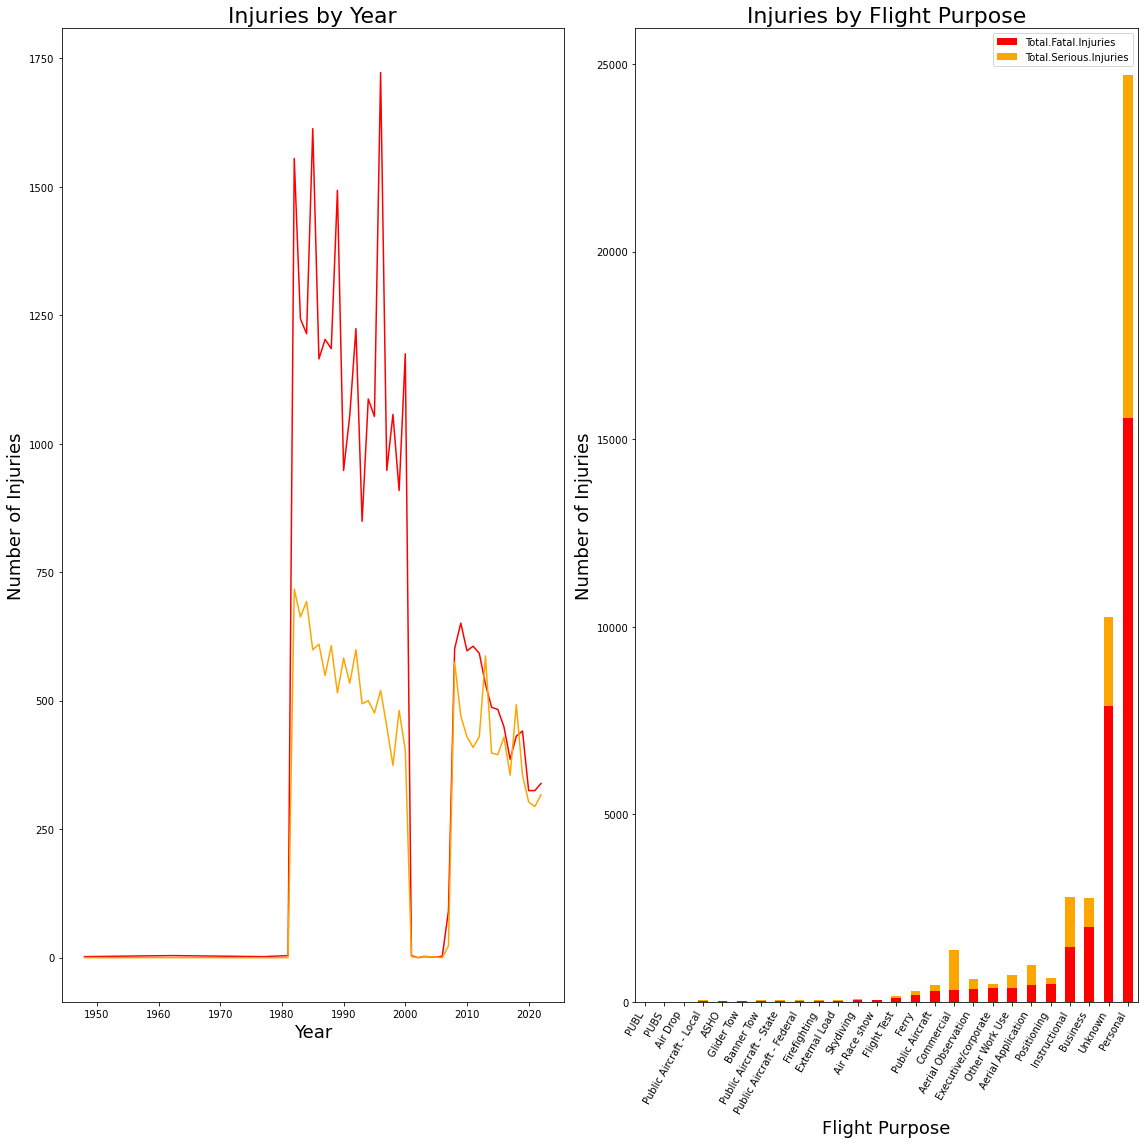

In [258]:
# Plotting
colors = ['red', 'orange', 'yellow', 'green']
fig, axs = plt.subplots(1, 2, figsize=(16, 16))


axs[0].plot(df_agg_inj_by_year.index, df_agg_inj_by_year['Total.Fatal.Injuries'],  color = 'red')
axs[0].plot(df_agg_inj_by_year.index, df_agg_inj_by_year['Total.Serious.Injuries'], color = 'orange')
axs[0].set_title('Injuries by Year', fontsize = 22)
axs[0].set_xlabel('Year', fontsize = 18)
axs[0].set_ylabel('Number of Injuries', fontsize = 18)


df_agg_inj_by_flight.plot(kind='bar', stacked=True, ax=axs[1], color = colors)
axs[1].set_title('Injuries by Flight Purpose', fontsize = 22)
axs[1].set_xlabel('Flight Purpose', fontsize = 18)
axs[1].set_ylabel('Number of Injuries', fontsize = 18)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60, ha='right')


plt.tight_layout()

#save 
#axs[0].figure.savefig(os.path.join(directory_out, 'Inj_By_Year_Unfiltered.jpeg'))
#axs[1].figure.savefig(os.path.join(directory_out, 'Inj_By_FlightPurpose_Unfiltered.jpeg'))


Personal              41407
Instructional          8776
Unknown                6322
Aerial Application     4112
Business               3527
Positioning            1227
Other Work Use          975
Commercial              974
Ferry                   729
Aerial Observation      673
Name: Purpose.of.flight, dtype: int64


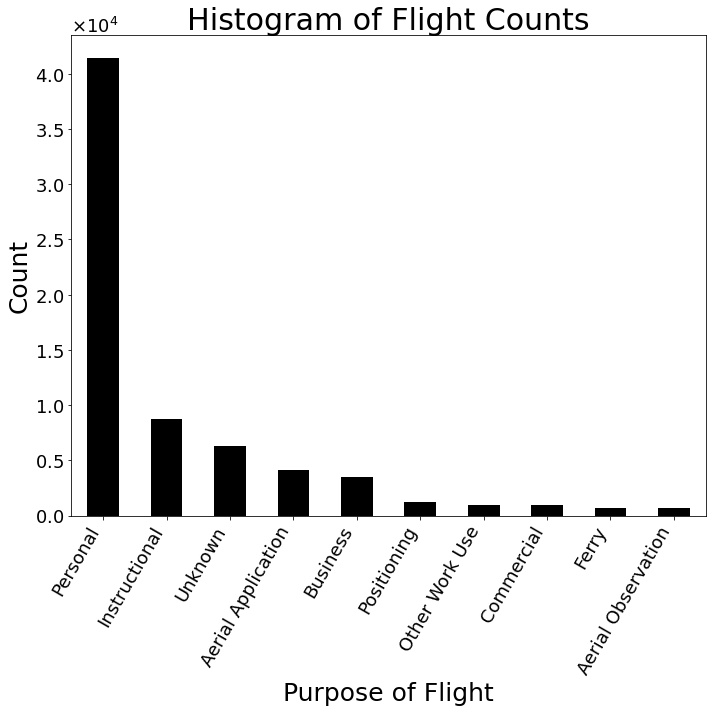

In [275]:
from matplotlib.ticker import ScalarFormatter

# Plotting
top10_fligt_by_purpose = df_accidents_clean['Purpose.of.flight'].value_counts().nlargest(10)
print(top10_fligt_by_purpose)

# Get the counts of each category
counts = df_accidents_clean['Purpose.of.flight'].value_counts().nlargest(10)
fig, axs_1 = plt.subplots(figsize=(10, 10))
# Plot a histogram
counts.plot(kind='bar', ax = axs_1, color = 'black')

# Add labels and title
plt.xlabel('Purpose of Flight', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.title('Histogram of Flight Counts', fontsize = 30)
plt.xticks(fontsize = 18,rotation = 60, ha='right');
plt.yticks(fontsize = 18);
axs_1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axs_1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs_1.yaxis.get_major_formatter().set_powerlimits((0, 1))
axs_1.yaxis.offsetText.set_fontsize(18)

plt.tight_layout()
axs_1.figure.savefig(os.path.join(directory_out, 'Hist_Flights.jpeg'))

## 4. Exploratory analysis: additional filtering.

Takeaway from the plot: flying got safer. Another takeaway is that we can narrow down the ```Year``` range to after 2006 since there's a gap in the data after 2001 and we would like to consider more modern aircrafts for analysis.
We can also narrow down the Flight Purpose to the following cathegories: Business, Commercial, Instructional, Aerial Application.

In [276]:
# repeating the analysis above, filtering out data prior to 2005
df_accidents_slice = df_accidents_slice[df_accidents_slice['Year'] > 2006]
flight_categories_of_interest = ['Business', 'Commercial', 'Instructional', 'Personal']
df_accidents_slice = df_accidents_slice[df_accidents_slice['Purpose.of.flight'].isin(flight_categories_of_interest)]
df_accidents_clean = df_accidents_slice.dropna()

In [277]:
df_accidents_clean['Year'] = df_accidents_clean['Year'].astype(int)
# injury by years
injury_by_year_cols = ['Year', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']
df_agg_inj_by_year = df_accidents_clean[injury_by_year_cols].groupby('Year').sum()

#injury by purpose of the flight
injury_by_flight_cols = ['Purpose.of.flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']
df_agg_inj_by_flight = df_accidents_clean[injury_by_flight_cols].groupby('Purpose.of.flight').sum()

df_agg_inj_by_flight = df_agg_inj_by_flight.sort_values(by=['Total.Fatal.Injuries', 'Total.Serious.Injuries'],\
                                  ascending=[True, True])

<ipython-input-277-94ef7ce3d930>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accidents_clean['Year'] = df_accidents_clean['Year'].astype(int)


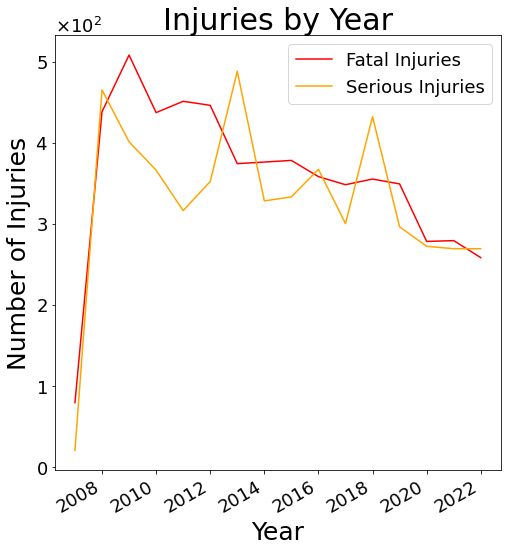

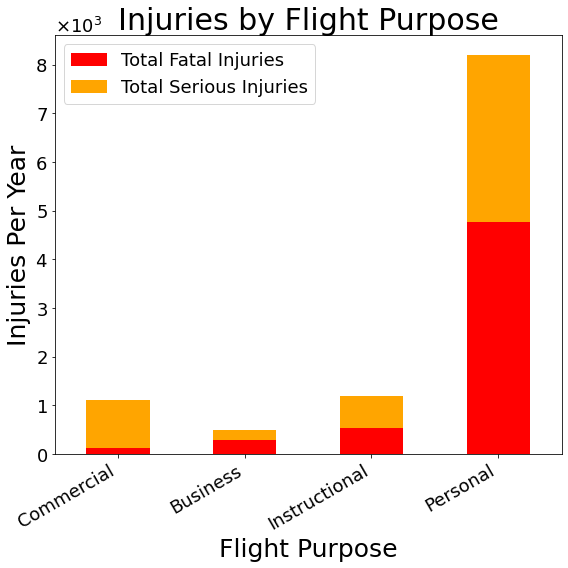

In [287]:
# Production Plotting
colors = ['red', 'orange']
fig, axs_1 = plt.subplots(figsize=(8, 8))

axs_1.plot(df_agg_inj_by_year.index, df_agg_inj_by_year['Total.Fatal.Injuries'],  \
           label='Fatal Injuries', color = 'red')
axs_1.plot(df_agg_inj_by_year.index, df_agg_inj_by_year['Total.Serious.Injuries'], \
           label='Serious Injuries', color = 'orange')
axs_1.set_title('Injuries by Year', fontsize = 30)
axs_1.set_xlabel('Year', fontsize = 25)
axs_1.set_ylabel('Number of Injuries', fontsize = 25)
axs_1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axs_1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs_1.yaxis.get_major_formatter().set_powerlimits((0, 1))
axs_1.yaxis.offsetText.set_fontsize(18)

plt.xticks(fontsize =18,rotation=30, ha='right')
plt.yticks(fontsize =18)


legend = axs_1.get_legend()
plt.legend(fontsize =18)

fig, axs_2 = plt.subplots(figsize=(8, 8))

df_agg_inj_by_flight.plot(kind='bar', stacked=True, ax=axs_2, color = colors)

axs_2.set_title('Injuries by Flight Purpose', fontsize = 30)
axs_2.set_xlabel('Flight Purpose', fontsize = 25)
axs_2.set_ylabel('Injuries Per Year', fontsize = 25)
axs_2.set_xticklabels(axs_2.get_xticklabels(), rotation=30, ha='right', fontsize =18)
axs_2.tick_params(axis='y', labelsize=18)
axs_2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axs_2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs_2.yaxis.get_major_formatter().set_powerlimits((0, 1))
axs_2.yaxis.offsetText.set_fontsize(18)

plt.legend(fontsize =18)
legend = axs_2.get_legend()
legend.get_texts()[0].set_text('Total Fatal Injuries')
legend.get_texts()[1].set_text('Total Serious Injuries')

plt.tight_layout()

#save plots
axs_1.figure.savefig(os.path.join(directory_out, 'Inj_By_Year_Filtered.jpeg'))
axs_2.figure.savefig(os.path.join(directory_out, 'Inj_By_FlightPurpose_Filtered.jpeg'))


## 4. Exploratory analysis: analyzing flights data.

In this section we are going to visualize personal flight injuries by most popular make and model.
Aircraft safety rating is gentrally defined as a number of total fatalities divied by the number of total flights.
We do not have the data on total number of flights per make and model, so we'll use the number of total occurences in our dataset instead.
Our objective is to establish an analysis pipeline to answer the business question. We'll add a combined make and model column to the dataset then write several aux functions for counting and ordering the categorical values in it.

In [232]:
#save the subset 
file_name = 'AviationAccidents_AY_clean_subset.csv'
file_path_Save = os.path.join(directory_out, file_name)
df_accidents_clean.to_csv(file_path_Save, index=False)

In [279]:
# Supplemental function selecting top n makes and models
def inj_top_n_make_model(df_slice, n):
    # select top n make and model
    
    top_n_makes_models_count = df_slice['Make.Model'].value_counts().nlargest(n)

    top_n_makes_models_idx = top_n_makes_models_count.index
    df_top_n_makesmodel = df_slice[df_slice['Make.Model'].isin(top_n_makes_models_idx)]

    #select injury columns
    columns_injury_by_make = ['Total.Fatal.Injuries', 'Total.Serious.Injuries','Make.Model']

    # select subset of injury columns
    df_agg_inj_by_make_model = df_top_n_makesmodel[columns_injury_by_make].groupby('Make.Model').sum()
    # sort
    df_agg_inj_by_make_model = df_agg_inj_by_make_model.sort_values(\
                                                                 by=['Total.Fatal.Injuries','Total.Serious.Injuries'],\
                                                                 ascending=[True, True])
    df_agg_inj_by_make_model['Count'] = top_n_makes_models_count;
    
    return df_agg_inj_by_make_model

In [280]:
#supplemental function to normalize the injuries by report count
def norm_inj_top_n_make_model(df_top_n):
    #injury columns
    columns_inj = ['Total.Fatal.Injuries', 'Total.Serious.Injuries']
    #create new dataframe
    df_norm = pd.DataFrame({'Fatal per Make Model':\
                        df_top_n['Total.Fatal.Injuries']/df_top_n['Count'],\
                        'Serious per Make Model':\
                        df_top_n['Total.Serious.Injuries']/df_top_n['Count']})

    # sort
    df_norm = df_norm.sort_values(by=['Fatal per Make Model', 'Serious per Make Model'],\
                                  ascending=[True, True])
    return df_norm

In [288]:
# aggregate over commercial, business, instructional purposes
pers_accidents = df_accidents_clean[df_accidents_clean['Purpose.of.flight'] == 'Personal']
df_agg_pers = inj_top_n_make_model(pers_accidents, 20)
df_pers_norm = norm_inj_top_n_make_model(df_agg_pers)

commercial_accidents = df_accidents_clean[df_accidents_clean['Purpose.of.flight'] == 'Commercial']
df_agg_comm = inj_top_n_make_model(commercial_accidents, 20)
df_comm_norm = norm_inj_top_n_make_model(df_agg_comm)

business_accidents = df_accidents_clean[df_accidents_clean['Purpose.of.flight'] == 'Business']
df_agg_bus = inj_top_n_make_model(business_accidents, 20)
df_bus_norm = norm_inj_top_n_make_model(df_agg_bus)

instructional_accidents = df_accidents_clean[df_accidents_clean['Purpose.of.flight'] == 'Instructional']
df_agg_ins = inj_top_n_make_model(instructional_accidents, 20)
df_ins_norm = norm_inj_top_n_make_model(df_agg_ins)




,Total.Fatal.Injuries,Total.Serious.Injuries,Count
Make.Model,,,
Airbus A321,0.0,0.0,9
Bombardier Cl-600-2C10,0.0,0.0,7
Boeing 737-8H4,0.0,1.0,8
Boeing 777,0.0,1.0,29
Bombardier Cl-600-2B19,0.0,2.0,18


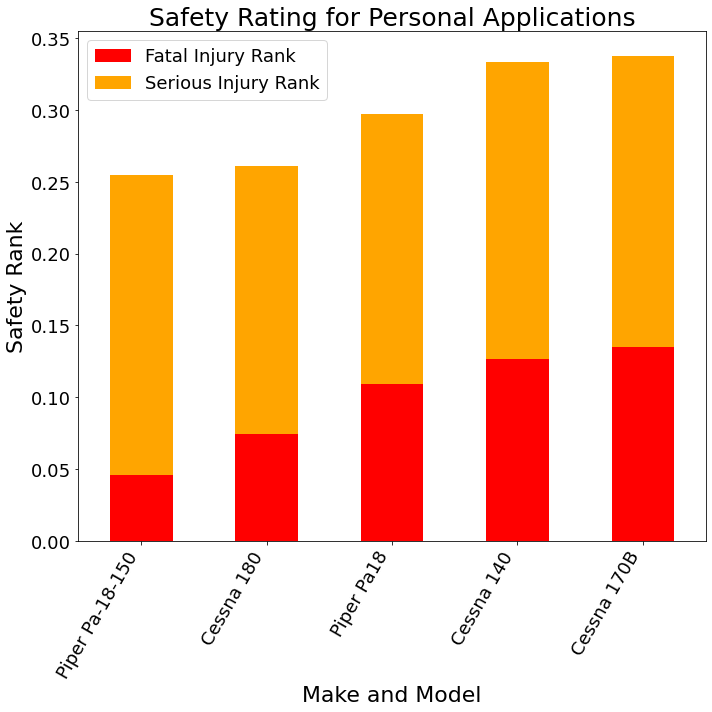

In [285]:
# Production plotting
colors = ['red', 'orange', 'yellow', 'green']
fig, axs_1 = plt.subplots(1, 1, figsize=(10, 10))

df_pers_norm.head(5).plot(kind='bar', stacked=True, ax=axs_1, color = colors)
# Labels
axs_1.set_title('Safety Rating for Personal Applications', fontsize = 25)
axs_1.set_xlabel('Make and Model', fontsize = 22)
axs_1.set_ylabel('Safety Rank', fontsize = 22)
axs_1.set_xticklabels(axs_1.get_xticklabels(), rotation=60, ha='right', fontsize = 18);
axs_1.tick_params(axis='y', labelsize=18)
axs_1.legend(fontsize =18)
legend = axs_1.get_legend()
legend.get_texts()[0].set_text('Fatal Injury Rank')
legend.get_texts()[1].set_text('Serious Injury Rank')

plt.tight_layout()
#save plots

axs_1.figure.savefig(os.path.join(directory_out, 'Inj_By_Flight_Personal.jpeg'))

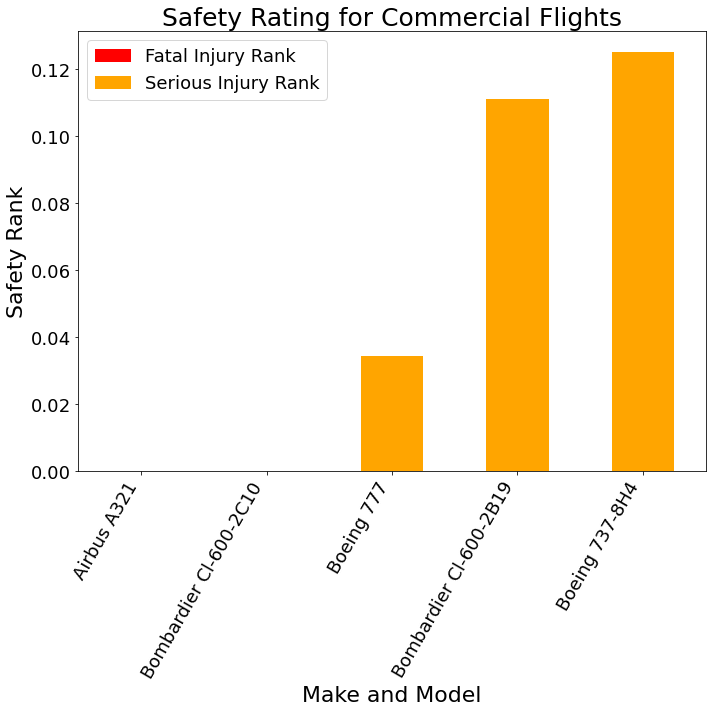

In [251]:
fig, axs_2 = plt.subplots(1, 1, figsize=(10, 10))
# Plotting
df_comm_norm.head(5).plot(kind='bar', stacked=True, ax=axs_2, color = colors)
# Labels
axs_2.set_title('Safety Rating for Commercial Flights', fontsize = 25)
axs_2.set_xlabel('Make and Model', fontsize = 22)
axs_2.set_ylabel('Safety Rank', fontsize = 22)
axs_2.set_xticklabels(axs_2.get_xticklabels(), rotation=60, ha='right', fontsize = 18);
axs_2.tick_params(axis='y', labelsize=18)
axs_2.legend(fontsize =18)
legend = axs_2.get_legend()
legend.get_texts()[0].set_text('Fatal Injury Rank')
legend.get_texts()[1].set_text('Serious Injury Rank')
plt.tight_layout()

axs_2.figure.savefig(os.path.join(directory_out, 'Inj_By_Flight_Commercial.jpeg'))

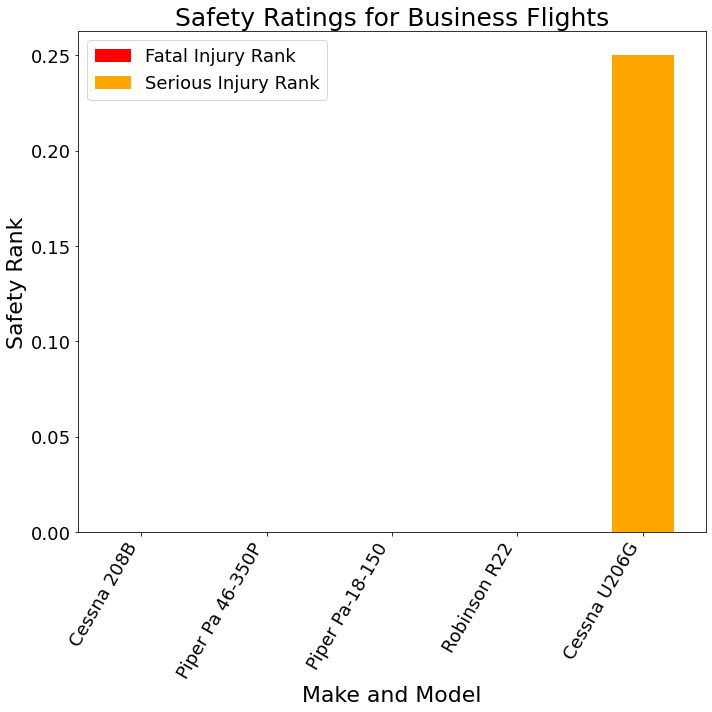

In [250]:
fig, axs_3 = plt.subplots(1, 1, figsize=(10, 10))
 # Plotting

df_bus_norm.head(5).plot(kind='bar', stacked=True, ax=axs_3, color = colors)
# Labels
axs_3.set_title('Safety Ratings for Business Flights', fontsize = 25)
axs_3.set_xlabel('Make and Model', fontsize = 22)
axs_3.set_ylabel('Safety Rank', fontsize = 22)
axs_3.set_xticklabels(axs_3.get_xticklabels(), rotation = 60, ha='right', fontsize = 18);
axs_3.tick_params(axis='y', labelsize = 18)
axs_3.legend(fontsize = 18)
legend = axs_3.get_legend()
legend.get_texts()[0].set_text('Fatal Injury Rank')
legend.get_texts()[1].set_text('Serious Injury Rank')
plt.tight_layout()

axs_3.figure.savefig(os.path.join(directory_out, 'Inj_By_Flight_Business.jpeg'))

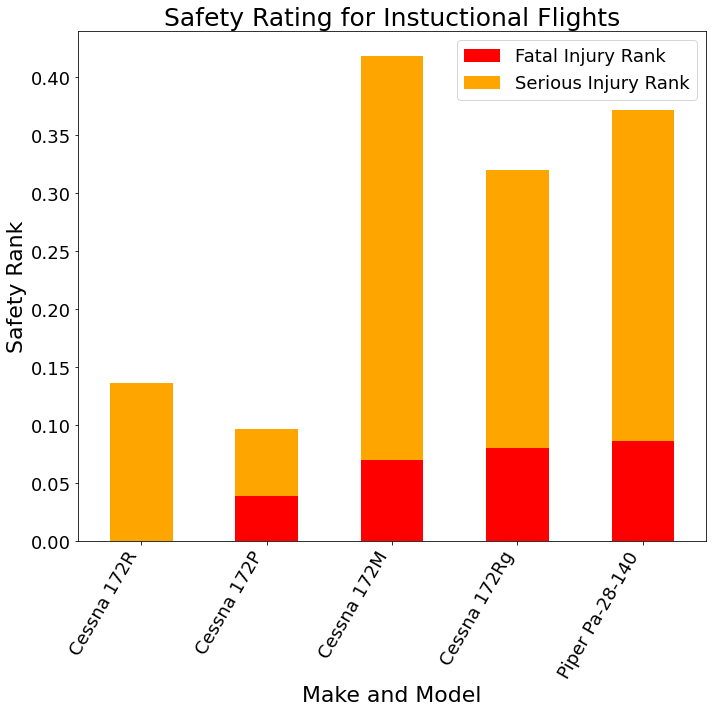

In [248]:
fig, axs_4 = plt.subplots(1, 1, figsize=(10, 10))
 # Plotting

df_ins_norm.head(5).plot(kind='bar', stacked=True, ax=axs_4, color = colors)
# Labels
axs_4.set_title('Safety Rating for Instuctional Flights', fontsize = 25)
axs_4.set_xlabel('Make and Model', fontsize = 22)
axs_4.set_ylabel('Safety Rank', fontsize = 22)
axs_4.set_xticklabels(axs_4.get_xticklabels(), rotation=60, ha='right', fontsize=18);
axs_4.tick_params(axis='y', labelsize=18)
axs_4.legend(fontsize =18)
legend = axs_4.get_legend()
legend.get_texts()[0].set_text('Fatal Injury Rank')
legend.get_texts()[1].set_text('Serious Injury Rank')

plt.tight_layout()

axs_4.figure.savefig(os.path.join(directory_out, 'Inj_By_Flight_Instructional.jpeg'))

In [289]:
# the 8 safest planes for personal use:
df_pers_norm.head(5)

,Fatal per Make Model,Serious per Make Model
Make.Model,,
Piper Pa-18-150,0.045455,0.209091
Cessna 180,0.074534,0.186335
Piper Pa18,0.109375,0.187500
Cessna 140,0.126437,0.206897
Cessna 170B,0.135135,0.202703


In [238]:
# the 8 safest planes for commercial use:
df_comm_norm.head(5)


,Fatal per Make Model,Serious per Make Model
Make.Model,,
Airbus A321,0.0,0.000000
Bombardier Cl-600-2C10,0.0,0.000000
Boeing 777,0.0,0.034483
Bombardier Cl-600-2B19,0.0,0.111111
Boeing 737-8H4,0.0,0.125000


In [292]:
# the 8 safest planes for business use:
df_bus_norm.head(5)

,Fatal per Make Model,Serious per Make Model
Make.Model,,
Cessna 208B,0.0,0.00
Piper Pa 46-350P,0.0,0.00
Piper Pa-18-150,0.0,0.00
Robinson R22,0.0,0.00
Cessna U206G,0.0,0.25


In [293]:
# the 8 safest planes for instructional use:
df_ins_norm.head(5)

,Fatal per Make Model,Serious per Make Model
Make.Model,,
Cessna 172R,0.000000,0.136364
Cessna 172P,0.038462,0.057692
Cessna 172M,0.069767,0.348837
Cessna 172Rg,0.080000,0.240000
Piper Pa-28-140,0.085714,0.285714


## Conclusion
The top-rated safety aircrafts would be:

| Commercial            | Business               | Instructional          |
|-----------------------|------------------------|------------------------|
| Airbus A321           | Cessna 208B            | Cessna 172R            |
| Bombardier Cl-600-2C10| Piper Pa 46-350P       | Cessna 172P            |
| Boeing 777            | Piper Pa-18-150        | Cessna 172M            |
| Bombardier Cl-600-2B19| Robinson R22           | Cessna 172Rg           |
| Boeing 737-8H4        | Cessna U206G	         | Piper Pa-28-140        |
